In [1]:
from pathlib import Path
from sklearn.model_selection import train_test_split
import numpy as np
from livelossplot.keras import PlotLossesCallback
import matplotlib.pyplot as plt
import seaborn as sns

from hyperas.distributions import uniform, choice
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Input
from keras import regularizers
from keras.callbacks import LearningRateScheduler, Callback
from keras.models import model_from_json

import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import keras

Using TensorFlow backend.


In [2]:
## For reproducibility
from numpy.random import seed
seed(9251996)

In [3]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 40:
        lrate = 0.0005
    if epoch > 60:
        lrate = 0.0003
    if epoch > 80:
        lrate = 0.0001
    if epoch > 100:
        lrate = 0.00003  
    return lrate

In [4]:
def data():
    train_values = pd.read_csv('train_values.csv', index_col='patient_id')
    train_labels = pd.read_csv('train_labels.csv', index_col='patient_id')
    train_labels.heart_disease_present.value_counts().plot.bar(title='Number with Heart Disease')
    #selected_features = ['age', 
    #                     'sex', 
    #                     'max_heart_rate_achieved', 
    #                     'resting_blood_pressure']
    selected_features =['slope_of_peak_exercise_st_segment',
    'resting_blood_pressure',
    'chest_pain_type',
    'num_major_vessels',
    'fasting_blood_sugar_gt_120_mg_per_dl',
    'resting_ekg_results',
    'serum_cholesterol_mg_per_dl',
    'oldpeak_eq_st_depression',
    'sex',
    'age',
    'max_heart_rate_achieved',
    'exercise_induced_angina']
    train_values_subset = train_values[selected_features]
    predictors =train_values_subset
    target = train_labels.heart_disease_present
    X_train,X_val,Y_train,Y_val = train_test_split(predictors,target,test_size=0.10,random_state=0)

    return X_train, Y_train,X_val,Y_val

In [5]:
def create_model(X_train, Y_train,X_val,Y_val):
    """
    Keras model function.
    """

    inshape = 12
    outshape = 1
    min_hlayers=3

    model = Sequential()
    for i in range(min_hlayers):
        if i==0:
            model.add(Dense({{ choice(range(1024)) }},input_shape=(inshape,)))
            model.add(Activation({{ choice(['relu','elu']) }})) ## Choose between relu or signmoid activation
            model.add(Dropout({{ uniform(0,1) }})) ## Choose dropout value using uniform distribution of values from 0 to 1
        else:
            model.add(Dense({{ choice(range(1024)) }}))
            model.add(Activation({{ choice(['relu','elu']) }}))
            model.add(Dropout({{ uniform(0,1) }}))

    model.add(Dense(outshape))
    model.add(Activation('sigmoid'))
   #model.add(Activation({{choice(['softmax','sigmoid']) }}))

    ## Hyperparameterization of optimizers and learning rate
    _adam = keras.optimizers.Adam(lr={{choice([10**-3, 10**-2, 10**-1])}})
    _rmsprop = keras.optimizers.RMSprop(lr={{choice([10**-3, 10**-2, 10**-1])}})
    _sgd = keras.optimizers.SGD(lr={{choice([10**-3, 10**-2, 10**-1])}})

    opt_choiceval = {{ choice( ['_adam', '_rmsprop', '_sgd'] ) }}

    if opt_choiceval == '_adam':
        optim = _adam
    elif opt_choiceval == '_rmsprop':
        optim = _rmsprop
    else:
        optim = _sgd
                      
    model.summary()
    model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=optim)
                      
    model.fit(X_train, Y_train,
        batch_size=256,
        epochs=125,
        verbose=2,
        validation_data=(X_val, Y_val), callbacks=[PlotLossesCallback()])

    loss, acc = model.evaluate(X_val, Y_val)
    predicted = model.predict(X_val)

    print('Test accuracy:', loss)
    return {'loss': 0+loss, 'status': STATUS_OK, 'model': model}


In [6]:
def main():

    trials =Trials()
    best_run, best_model = optim.minimize(model=create_model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=100,
                                          trials=trials,
                                        notebook_name='main')
    X_train, Y_train, X_val, Y_val = data()
    print("\n >> Hyperparameters  ")
    for t in best_run.items():
        print("[**] ",t[0],": ", t[1])

    print("\nSaving model...")
    model_json = best_model.to_json()
    with open("model_num.json","w") as json_file:
        json_file.write(model_json)
    best_model.save_weights("model_num.h5")


In [7]:
def predict():
    selected_features =['slope_of_peak_exercise_st_segment',
    'resting_blood_pressure',
    'chest_pain_type',
    'num_major_vessels',
    'fasting_blood_sugar_gt_120_mg_per_dl',
    'resting_ekg_results',
    'serum_cholesterol_mg_per_dl',
    'oldpeak_eq_st_depression',
    'sex',
    'age',
    'max_heart_rate_achieved',
    'exercise_induced_angina']
    test_values = pd.read_csv('test_values.csv', index_col='patient_id')
    X_test = test_values[selected_features]
    # name = sys.argv[1]
    json_file = open("model_num.json" , 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("model_num.h5")
    print("Loaded model...")

    # evaluate loaded model on test data

    predictions=loaded_model.predict(X_test, batch_size=128)
    submission_format = pd.read_csv('submission_format.csv', index_col='patient_id')
    my_submission = pd.DataFrame(data=predictions,
                         columns=submission_format.columns,
                         index=submission_format.index)
    my_submission.head()
    my_submission.to_csv('submission5.csv')



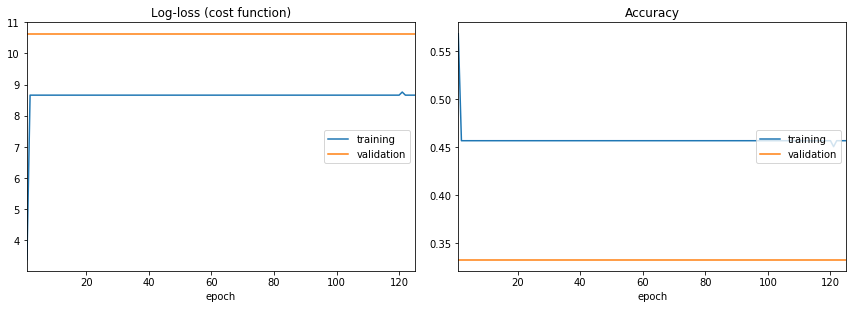

Log-loss (cost function):                                                      
training   (min:    3.388, max:    8.760, cur:    8.660)
validation (min:   10.628, max:   10.628, cur:   10.628)

Accuracy:
training   (min:    0.451, max:    0.568, cur:    0.457)
validation (min:    0.333, max:    0.333, cur:    0.333)
18/18 [==============================]                                         
 - 0s 1ms/step                                                                 

Test accuracy:                                                                 
10.628256797790527                                                             
100%|███████| 100/100 [2:05:35<00:00, 86.74s/it, best loss: 0.6055876612663269]

 >> Hyperparameters  
[**]  Activation :  1
[**]  Activation_1 :  1
[**]  Activation_2 :  0
[**]  Dense :  652
[**]  Dense_1 :  369
[**]  Dropout :  0.16277122657207727
[**]  Dropout_1 :  0.6669332967024697
[**]  lr :  0
[**]  lr_1 :  0
[**]  lr_2 :  1
[**]  opt_choiceval :  0



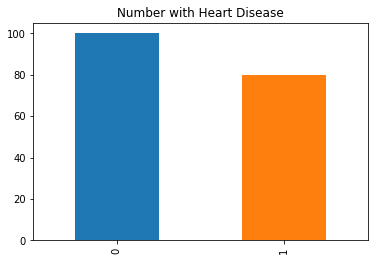

In [8]:
main()
print("done.. Training")
predict()